In [236]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.stats as stats

#VADER sentiment: http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from pandas.plotting import autocorrelation_plot, lag_plot

Some lines in the csv were split into multiple lines due to carriage returns in the actual twitter text. Some lines had an incorrect number of fields due to being split into multiple lines due to carriage returns in the actual twitter text and other errors. Therefore we parse by hand instead of letting Pandas handle it. This may take some time.

In [55]:
#Specify column names in header (not including datetime -- that goes in index)
header = ['id1', 'id2', 'text']
columns = {h: [] for h in header}
index = []

with open('raw data/Twitter_big/training_set_tweets.txt', 'rb') as in_file:
    i = 0 #Line index
    
    #Loop through lines in file
    for line in in_file.readlines():
        
        #Count the number of tabs ('\t') in the line
        numtabs = line.count(b'\t')
        
        #We should have 3 tabs for 4 rows
        try: assert(numtabs == 3)
            
        #Do something if we have some number other than 3 tabs. We may try to fix the lines, but here we just move on
        except AssertionError:
            #Optionally print the lines we omit
            #print("Omitted line %s. Had %s tabs instead of 3." %(i, numtabs), '\n\n', line, '\n\n')
            #Move on to next item in loop
            continue
            
        #Split the line on each tab to make a list of numtabs+1 entries
        row = line.split(b'\t')
        
        #Remove carriage return markers from end of line
        row[-1] = row[-1].replace(b'\r\n', b'')
        
        #Convert datetime entry to pandas indexable datetime object. If this cannot be done (format error), skip line
        try:
            row[-1] = pd.to_datetime(row[-1].decode("utf-8", 'ignore'), format = '%Y\%m\%d')
        except ValueError:
            #Optionally print the lines we omit
            #print("Omitted line %s. Incorrect datetime format" %(i), '\n\n', row[-1], '\n\n')
            continue
        
        #Pair row entries with column name (except for datetime)
        for h, entry in zip(header, row[:-1]):
            #decode raw text (bytes) as utf-8
            columns[h].append(entry.decode("utf-8", 'ignore'))
            
        #Datetime as index
        index.append(row[-1])
                  
        i = i+1 #Update line index
        
columns['datetime'] = index

#Make into dataframe
tweets = pd.DataFrame(columns)

In [111]:
#Build sentiment dataframe using VADER. This may take some time.

cols = {'neg': [], 'neu': [], 'pos': [], 'compound': []}
sid = SentimentIntensityAnalyzer()
for text in tweets['text']:
    ss = sid.polarity_scores(text)
    for k in ss:
        cols[k].append(ss[k])
sentiment = pd.DataFrame(cols)

In [112]:
#Merge tweet df with sentiment df
combined = pd.concat((tweets, sentiment), axis=1)
combined.index = pd.to_datetime(combined['datetime'])
del combined['datetime']

In [115]:
combined.head()

,id1,id2,text,compound,neg,neu,pos
datetime,,,,,,,
2009-12-03 18:41:07,60730027,6320951896,@thediscovietnam coo. thanks. just dropped yo...,0.4404,0.000,0.674,0.326
2009-12-03 18:31:01,60730027,6320673258,@thediscovietnam shit it ain't lettin me DM yo...,-0.5574,0.247,0.753,0.000
2009-12-03 18:01:51,60730027,6319871652,"@thediscovietnam hey cody, quick question...ca...",0.0000,0.000,1.000,0.000
2009-12-03 17:00:16,60730027,6318151501,@smokinvinyl dang. you need anything? I got ...,0.0000,0.000,1.000,0.000
2009-12-03 16:52:36,60730027,6317932721,"maybe i'm late in the game on this one, but th...",0.0000,0.000,1.000,0.000


In [114]:
combined.to_csv('raw data/Twitter_big/training_set_tweets_processed.csv', encoding='utf-8')

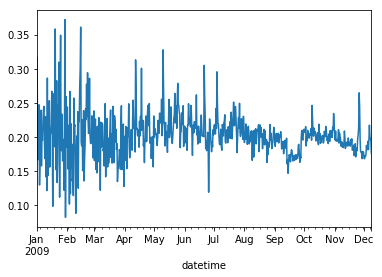

In [129]:
combined['compound']['2009'].resample('12H').apply(np.mean).plot()

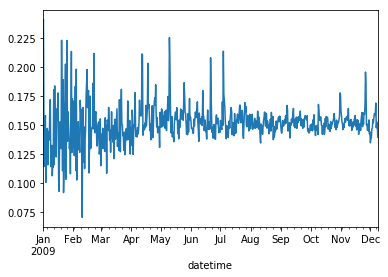

In [130]:
combined['pos']['2009'].resample('12H').apply(np.mean).plot()

In [248]:
what = 'compound'
scale = '7D'

mean = combined[what]['2009'].resample(scale).apply(np.mean)
var = combined[what]['2009'].resample(scale).apply(np.var)
n = combined[what]['2009'].resample(scale).apply(len)
sigmn = np.sqrt(var) / np.sqrt(n)

In [249]:
alpha = .05
q = stats.t.ppf(1-alpha/2, n-1)
upper = mean + q * sigmn
lower = mean - q * sigmn

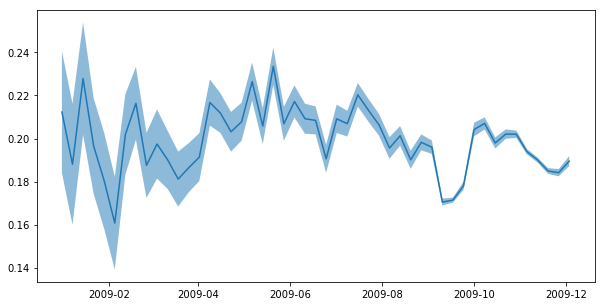

In [250]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mean)
ax.fill_between(mean.index, upper, lower, alpha = .5)